In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [59]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [60]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
86    0.223957  0.898048  0.869736  0.976773  0.974721  0.589335  0.966303   
296   0.823102  0.501514  0.223898  0.184752  0.373524  0.022147  0.173042   
1851  0.114888  0.875673  0.897160  0.252837  0.904374  0.575866  0.390625   
806   0.150139  0.958614  0.889520  0.202660  0.929154  0.593458  0.425828   
644   0.662674  0.580922  0.451126  0.145018  0.696990  0.042936  0.194465   
...        ...       ...       ...       ...       ...       ...       ...   
106   0.485348  0.479307  0.226053  0.167961  0.405289 -0.029192  0.183603   
1109  0.073904  1.000000  0.952204  0.963121  0.997006  0.983233  0.980798   
1277  0.222888  0.968035  0.910480  0.951418  0.903043  0.847444  0.979857   
130   0.503529  0.465007  0.255436  0.153245  0.468152  0.042276  0.184074   
1830  0.247701  0.898721  0.702253  0.194149  0.771661  0.411765  0.256212   

            F9        F5       F7      F12        F8  
86    0.

In [61]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


# call the Encoder pkl file

In [62]:
import pickle

# Load the encoder model from the saved file
with open("all_pkl_file/Encoder_3.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [63]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



70/70 [==============================] - 0s 909us/step


21/21 [==============================] - 0s 913us/step


# tune D tree for Ada-Boost

In [64]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=True).fit(dataset)
encoded_X_n=scaler.transform(dataset)
encoded_X_train_n=scaler.transform(X_train)
encoded_X_test_n=scaler.transform(X_test)
encoded_X_train_n

array([[0.23379679, 0.97863392, 0.95318315, ..., 0.68601799, 0.0503    ,
        0.7676397 ],
       [0.14596791, 0.93623822, 0.93143976, ..., 0.41537204, 1.        ,
        0.393995  ],
       [0.13448128, 0.97644684, 0.81547502, ..., 0.26700736, 0.04291   ,
        0.30033361],
       ...,
       [0.2684492 , 0.83781965, 0.76591577, ..., 0.17269011, 0.0046385 ,
        0.26980817],
       [0.45582888, 0.60683042, 0.32908913, ..., 0.08086672, 0.24705   ,
        0.09874896],
       [0.48705882, 0.55888291, 0.28481881, ..., 0.08683565, 0.24645   ,
        0.13027523]])

In [65]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)

model_dt.fit(encoded_X_train_n, y_train)

DecisionTreeClassifier(max_depth=12, max_features='sqrt')

In [66]:
# Finding mean absolute error
preds = model_dt.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.022590361445783132

In [67]:
# Defining the best parameter with optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_dt = np.array(encoded_X_n)
target_train_tunned_dt = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds_dt = np.zeros((len(train_tunned_dt)))
abs_error_arr_dt=[]
def objective(trial):

 for train_index, val_index in (skf.split(encoded_X_n,label)):
    train_X, valid_X = train_tunned_dt[train_index], train_tunned_dt[val_index]
    train_Y, valid_Y = target_train_tunned_dt[train_index], target_train_tunned_dt[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
        'criterion':trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"]), #The function to measure the quality of a split.
        'splitter':trial.suggest_categorical('splitter',["best", "random"]),
        'max_features':trial.suggest_categorical('max_features',['sqrt','log2',1,2,3,4,5,6,7,8,9,10,11]), #a categorical value can be an integer
        'random_state':trial.suggest_int('random_state',0,5),


        }
    model = DecisionTreeClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds_dt[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
#  print(len(oof_preds_dt))
      
 mae = mean_absolute_error(target_train_tunned_dt, oof_preds_dt)
        
 return mae

In [68]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize')

[I 2024-02-12 13:59:25,613] A new study created in memory with name: no-name-dad85de7-b1af-4bc1-82cb-de08bd4776ed


In [69]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 13:59:25,700] Trial 0 finished with value: 0.02938517179023508 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 11, 'random_state': 0}. Best is trial 0 with value: 0.02938517179023508.


[I 2024-02-12 13:59:25,769] Trial 1 finished with value: 0.019891500904159132 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_features': 7, 'random_state': 1}. Best is trial 1 with value: 0.019891500904159132.
[I 2024-02-12 13:59:25,799] Trial 2 finished with value: 0.027576853526220614 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_features': 4, 'random_state': 3}. Best is trial 1 with value: 0.019891500904159132.
[I 2024-02-12 13:59:25,825] Trial 3 finished with value: 0.06103074141048825 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 1, 'random_state': 5}. Best is trial 1 with value: 0.019891500904159132.
[I 2024-02-12 13:59:25,839] Trial 4 finished with value: 0.021247739602169982 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 9, 'random_state': 2}. Best is trial 1 with value: 0.019891500904159132.
[I 2024-02-12 13:59:25,849] Trial 5 finished with value: 0.08453887884267632 and paramet

Number of finished trials: 100
Best trial: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 10, 'random_state': 3}


In [70]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.01763110307414105
  Params: 
    criterion: entropy
    splitter: best
    max_features: 10
    random_state: 3


In [71]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["criterion", "splitter","max_features","random_state"])
fig_study.show()


# tune Ada-Boost

In [72]:
# train the model with random parameter
from sklearn.ensemble import AdaBoostClassifier
# Preparing the regressor and fitting data with some parameters
dt_params = study.best_trial.params
model_dt = DecisionTreeClassifier(**dt_params)
#model_dt = estimator
#model = predictor = model_dt.fit()

model_Ada = AdaBoostClassifier(
        estimator=model_dt,
        n_estimators=180, # maximum number of estimators at which boosting is terminated
        learning_rate=1.2,
        algorithm="SAMME", #SAMME.R=real boosting algorithm
        
     )

model_Ada.fit(encoded_X_train_n, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_features=10,
                                                    random_state=3),
                   learning_rate=1.2, n_estimators=180)

In [73]:
# Finding mean absolute error
preds = model_Ada.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.018072289156626505

In [74]:
# Defining the best parameter with optuna

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_Ada= np.array(encoded_X_n)
target_train_tunned_Ada = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds_Ada = np.zeros((len(train_tunned_Ada)))
abs_error_arr_Ada=[]
def objective_Ada(trial):

 for train_index, val_index in (skf.split(encoded_X_n,label)):
    train_X, valid_X = train_tunned_Ada[train_index], train_tunned_Ada[val_index]
    train_Y, valid_Y = target_train_tunned_Ada[train_index], target_train_tunned_Ada[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
        'estimator':model_dt,
        'n_estimators':trial.suggest_int("n_estimators",50,500), # maximum number of estimators at which boosting is terminated
        'learning_rate':trial.suggest_float("learning_rate",1,3),
        'algorithm':trial.suggest_categorical("algorithm",["SAMME","SAMME.R"]),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model_2 = AdaBoostClassifier(**param)  
        
    model_2.fit(train_X,train_Y)
        
    preds = model_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds # preds gives total 3846 predicted value for valid_X

#  abs_error=np.abs(oof_preds-target_train_tunned).mean() 
#  abs_error_arr.append(abs_error)  
#  abs_error=np.abs(oof_preds-target_train).mean()
 
#  print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned_Ada, oof_preds_Ada)
        
 return mae

In [75]:
# this is the main optuna for optimizing a object-->"objective"
study_Ada = optuna.create_study(direction='minimize',study_name="Ada_tunning")

[I 2024-02-12 13:59:31,636] A new study created in memory with name: Ada_tunning


In [76]:

study_Ada.optimize(objective_Ada, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study_Ada.trials))
print('Best trial:', study_Ada.best_trial.params)

[I 2024-02-12 13:59:31,758] Trial 0 finished with value: 0.02034358047016275 and parameters: {'n_estimators': 343, 'learning_rate': 1.9382635768315488, 'algorithm': 'SAMME.R', 'random_state': 1}. Best is trial 0 with value: 0.02034358047016275.


[I 2024-02-12 13:59:31,847] Trial 1 finished with value: 0.016726943942133816 and parameters: {'n_estimators': 236, 'learning_rate': 1.5217950908036497, 'algorithm': 'SAMME', 'random_state': 2}. Best is trial 1 with value: 0.016726943942133816.
[I 2024-02-12 13:59:31,933] Trial 2 finished with value: 0.02034358047016275 and parameters: {'n_estimators': 65, 'learning_rate': 2.613265159076854, 'algorithm': 'SAMME', 'random_state': 5}. Best is trial 1 with value: 0.016726943942133816.
[I 2024-02-12 13:59:32,013] Trial 3 finished with value: 0.02034358047016275 and parameters: {'n_estimators': 186, 'learning_rate': 2.7937771525589055, 'algorithm': 'SAMME.R', 'random_state': 1}. Best is trial 1 with value: 0.016726943942133816.
[I 2024-02-12 13:59:32,093] Trial 4 finished with value: 0.016726943942133816 and parameters: {'n_estimators': 424, 'learning_rate': 2.1846390031193637, 'algorithm': 'SAMME.R', 'random_state': 2}. Best is trial 1 with value: 0.016726943942133816.
[I 2024-02-12 13:59:

Number of finished trials: 100
Best trial: {'n_estimators': 236, 'learning_rate': 1.5217950908036497, 'algorithm': 'SAMME', 'random_state': 2}


In [77]:
#evaluate the trial
print("Number of finished trials: ", len(study_Ada.trials))
print("Best trial:")
trial = study_Ada.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.016726943942133816
  Params: 
    n_estimators: 236
    learning_rate: 1.5217950908036497
    algorithm: SAMME
    random_state: 2


In [78]:
from matplotlib import pyplot as plt
fig_study_Ada = optuna.visualization.plot_parallel_coordinate(study_Ada, params=["n_estimators", "learning_rate","algorithm","random_state"])
fig_study_Ada.show()

# fit the Ada-Boost model

In [79]:

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

In [80]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_Ada = np.array(encoded_X_train_n)
target_train_Ada = np.array(y_train)

test_Ada = np.array(encoded_X_test_n) # or test_Ada = np.array(X)


test_preds_Ada = np.zeros((len(test_Ada)))
oof_preds_Ada = np.zeros((len(train_Ada)))

for train_index, val_index in tqdm(skf.split(encoded_X_train_n,y_train), total=5):
    train_X, valid_X = train_Ada[train_index], train_Ada[val_index]
    train_y, valid_y = target_train_Ada[train_index], target_train_Ada[val_index]
    ada_params = study_Ada.best_trial.params
    model_Ada_2 = AdaBoostClassifier(**ada_params,estimator=model_dt)
    model_Ada_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_Ada_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds
    # for test accuracy
    preds = model_Ada_2.predict(test_Ada)
    test_preds_Ada += (preds)/5
print(np.abs(oof_preds_Ada-target_train_Ada).mean())

100%|██████████| 5/5 [00:00<00:00, 57.08it/s]

0.027131782945736434


In [81]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_Ada=accuracy_score(target_test,test_preds_Ada.round())
print(test_Acc_Ada)

0.9894578313253012


In [82]:
#validation accuracy
valid_Acc=accuracy_score(target_train_Ada,oof_preds_Ada)
print(valid_Acc)

0.977390180878553


In [83]:
# train accuracy
train_Acc=model_Ada_2.score(encoded_X_train_n,y_train)
print(train_Acc)

0.9954780361757106


In [84]:
# test_accuracy
test_Acc=model_Ada_2.score(encoded_X_test_n,y_test)
print(test_Acc)

0.9864457831325302


# Evaluation

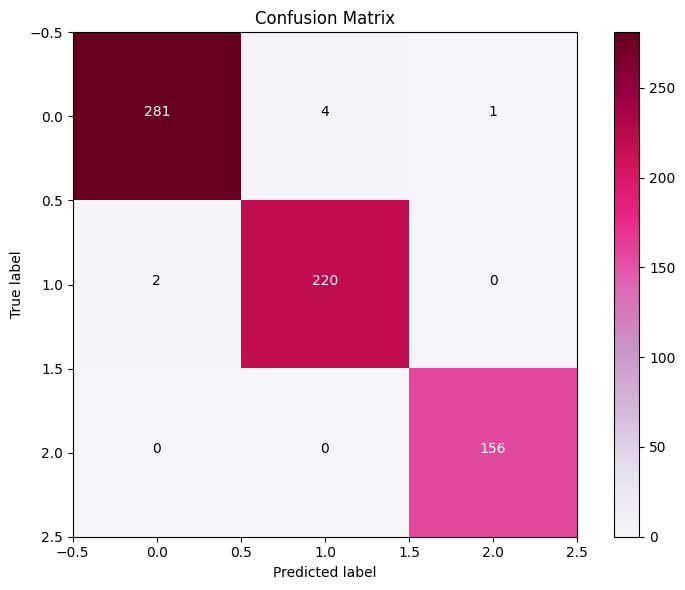

In [85]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_Ada.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
